# 2D Nuclear Segmentation with PanOpticFPN

In [1]:
import os
import errno

import numpy as np
import tensorflow as tf

import deepcell

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.2 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

6370107392/6370099814 [==============================] - 175s 0us/step
X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the RetinaMask Model

Here we instantiate a `RetinaMask` model from `deepcell.model_zoo` for object detection and masking.

In [5]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(y_train.astype('int'))

num_classes = 1  # "object" is the only class

In [6]:
from deepcell import model_zoo

backbone = 'resnet50'

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaMask(
    backbone=backbone,
    input_shape=X_train.shape[1:],
    panoptic=True,
    num_semantic_heads=2,
    num_semantic_classes=[1, 1],
    class_specific_filter=False,
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

Instructions for updating:
Use fn_output_signature instead


## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

**min_objects**: The minimum number of objects in every training image. Images with fewer than `min_objects` objects will be discarded.

In [7]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = '{}_retinanet'.format(backbone)

n_epoch = 5  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

min_objects = 3

transforms = ['inner-distance', 'outer-distance']
transforms_kwargs = {}

### Create the DataGenerators

The `RetinaNetDataGenerator` outputs a raw image (`X`) with bounding boxes and classifications for every object in the labeled data (`y`).

In [8]:
from deepcell.image_generators import RetinaNetGenerator

# this will do preprocessing and realtime data augmentation
datagen = RetinaNetGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = RetinaNetGenerator()

In [9]:
from deepcell.utils.retinanet_anchor_utils import guess_shapes

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    include_bbox=True,
    include_masks=True,
    panoptic=True,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    pyramid_levels=pyramid_levels,
    min_objects=min_objects,
    anchor_params=anchor_params,
    compute_shapes=guess_shapes,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    include_bbox=True,
    include_masks=True,
    panoptic=True,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    pyramid_levels=pyramid_levels,
    min_objects=min_objects,
    anchor_params=anchor_params,
    compute_shapes=guess_shapes,
    batch_size=batch_size)

### Compile the model with a loss function

Each output is trained with it's own loss function, regression loss is used for the bounding box task while a different loss is used for the categorical task. Both of these are encapsulated by the `RetinaNetLosses` class.

In [10]:
from deepcell.losses import RetinaNetLosses

retinanet_losses = RetinaNetLosses(
    sigma=3.0, alpha=0.25, gamma=2.0,
    mask_size=(28, 28), iou_threshold=0.5)


panoptic_weight = 0.1


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return panoptic_weight * losses.weighted_categorical_crossentropy(
                y_true, y_pred, n_classes=n_classes)
        return panoptic_weight * tf.keras.losses.MSE(y_true, y_pred)
    return _semantic_loss


loss = {
    'regression': retinanet_losses.regress_loss,
    'classification': retinanet_losses.classification_loss,
    'masks': retinanet_losses.mask_loss
}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(num_classes)

In [11]:
model.compile(loss=loss, optimizer=optimizer)

## Train the RetinaMask model

Create a prediction model, convert the data generators to `Datasets`, and call `fit()` on the compiled model, along with a default set of callbacks.

In [12]:
from tensorflow.python.data import Dataset

# Some versions of TensorFlow 2.x do not handle multiple
# outputs in X or y, but is compatible with a Dataset instead.

input_type_dict = {'input': tf.float32, 'boxes_input': tf.float32}
input_shape_dict = {
    'input': tuple([None] + list(train_data.x.shape[1:])),
    'boxes_input': (None, None, 4)
}

output_type_dict = {
    'regression': tf.float32,
    'classification': tf.float32,
    'masks': tf.float32,
}
output_shape_dict = {
    'regression': (None, None, None),
    'classification': (None, None, None),
    'masks': (None, None, None),
}

train_dataset = Dataset.from_generator(
    lambda: train_data,
    (input_type_dict, output_type_dict),
    output_shapes=(input_shape_dict, output_shape_dict))

val_dataset = Dataset.from_generator(
    lambda: val_data,
    (input_type_dict, output_type_dict),
    output_shapes=(input_shape_dict, output_shape_dict))

for i, n in enumerate(range(len(transforms))):
    output_type_dict['semantic_{}'.format(i)] = tf.float32
    output_shape_dict['semantic_{}'.format(i)] = (None, None, None, n)

In [13]:
from deepcell.model_zoo.retinamask import retinamask_bbox

prediction_model = retinamask_bbox(
    model,
    nms=True,
    num_semantic_heads=len(transforms),
    panoptic=True,
    anchor_params=anchor_params,
    class_specific_filter=False)

In [14]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus
from deepcell.callbacks import RedirectModel, Evaluate

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

eval_callback = RedirectModel(
    Evaluate(val_data,
             iou_threshold=0.5,
             score_threshold=.01,
             max_detections=100,
             weighted_average=True),
    prediction_model)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


5162/5162 [==============================] - ETA: 0s - loss: 1.8086 - regression_loss: 1.2900 - classification_loss: 0.2177 - masks_loss: 0.2983 - semantic_0_loss: 7.1615e-04 - semantic_1_loss: 0.0018
Epoch 00001: val_loss improved from inf to 1.44494, saving model to /data/models/resnet50_retinanet.h5
5162/5162 [==============================] - 519s 101ms/step - loss: 1.8086 - regression_loss: 1.2900 - classification_loss: 0.2177 - masks_loss: 0.2983 - semantic_0_loss: 7.1615e-04 - semantic_1_loss: 0.0018 - val_loss: 1.4449 - val_regression_loss: 1.0112 - val_classification_loss: 0.1827 - val_masks_loss: 0.2506 - val_semantic_0_loss: 1.5378e-04 - val_semantic_1_loss: 3.3023e-04
Epoch 2/5
5162/5162 [==============================] - ETA: 0s - loss: 1.3546 - regression_loss: 0.9466 - classification_loss: 0.1540 - masks_loss: 0.2535 - semantic_0_loss: 1.5277e-04 - semantic_1_loss: 4.3804e-04
Epoch 00002: val_loss improved from 1.44494 to 1.30454, saving model to /data/models/resnet50_re

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [15]:
# Set up the prediction model
from deepcell import model_zoo

# Set up the prediction model
prediction_model = model_zoo.retinamask_bbox(
    model,
    nms=True,
    anchor_params=anchor_params,
    num_semantic_heads=2,
    panoptic=True,
    class_specific_filter=False)

Image Number: 1286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


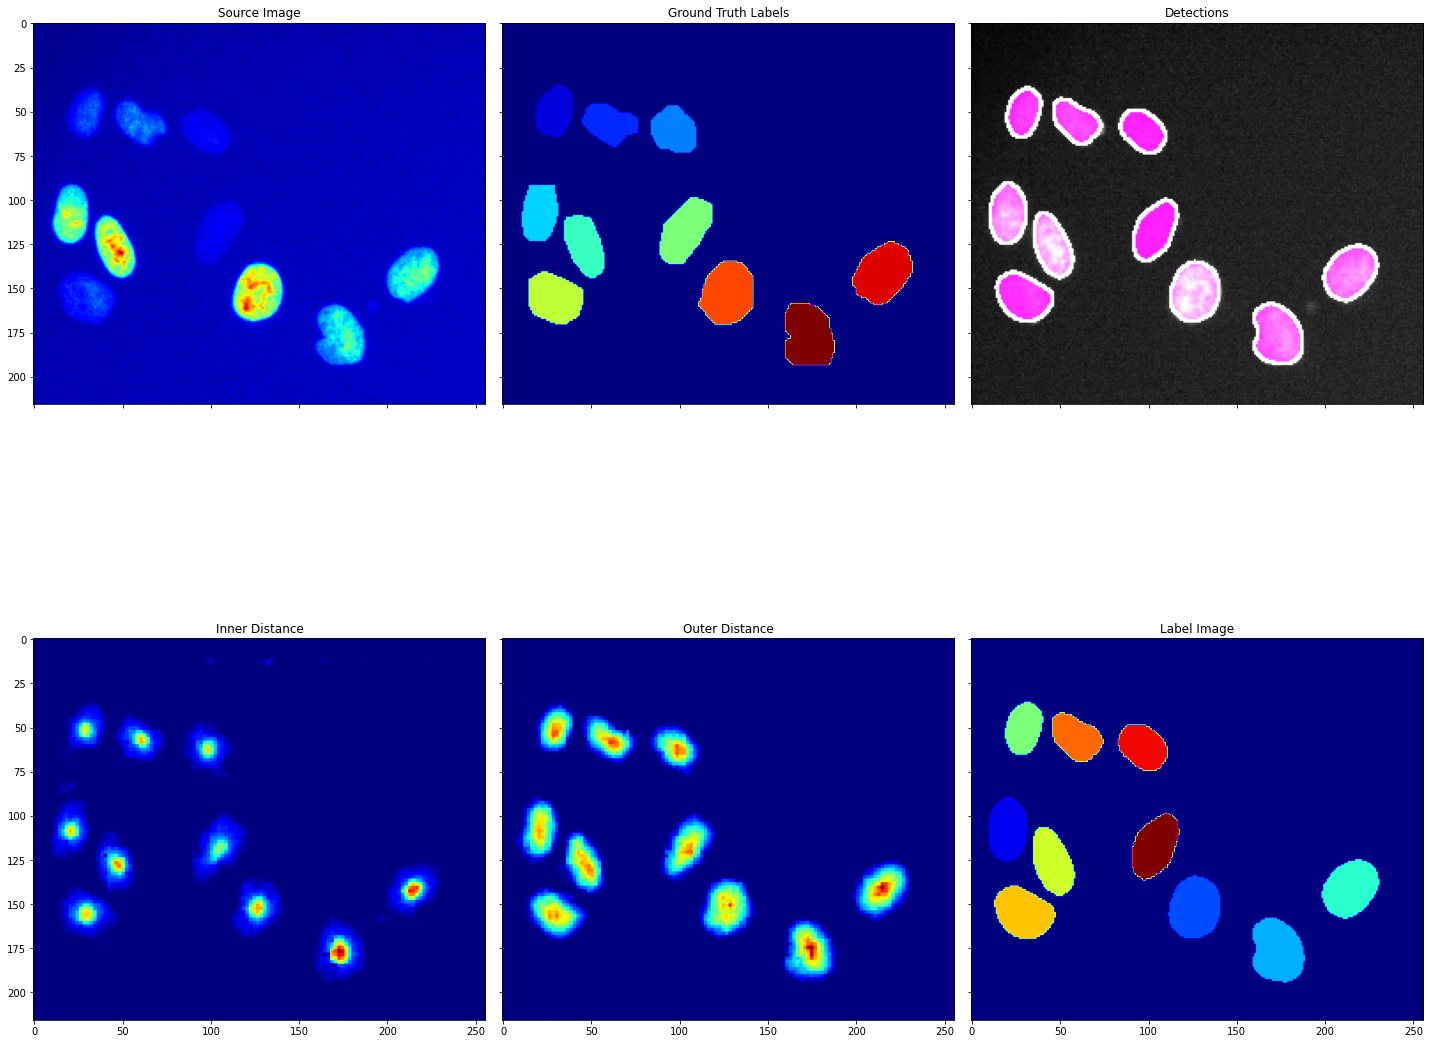

In [16]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from skimage.transform import resize 
from skimage.measure import label
from skimage.exposure import equalize_hist, rescale_intensity

from deepcell_toolbox import retinamask_semantic_postprocess
from deepcell.utils.plot_utils import draw_detections, draw_masks


index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

results = prediction_model.predict(image)

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

boxes  = results[-6]
scores = results[-5]
labels = results[-4]
masks  = results[-3]
semantic = results[-2:]

label_image = retinamask_semantic_postprocess(results[:-1])

# copy to draw on
draw = image.copy()

# draw the masks
draw_masks(draw, boxes[0], scores[0], masks[0], score_threshold=0.5)

display_image = image.copy()
display_image = rescale_intensity(display_image, out_range=(-1, 1))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(display_image[..., -1], cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

ax[3].imshow(semantic[0][0, ..., 0], cmap='jet')
ax[3].set_title('Inner Distance')
            
ax[4].imshow(semantic[1][0, ..., 0], cmap='jet')
ax[4].set_title('Outer Distance')

ax[5].imshow(label_image[0], cmap='jet')
ax[5].set_title('Label Image')

plt.tight_layout()
plt.show()